In [1]:
#import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os
from tqdm import tqdm
from IPython.display import Image as ImagePy, display
import warnings
import h5py
import matplotlib.pyplot as plt
#import torchvision.transforms as transforms
warnings.filterwarnings('ignore')

In [ ]:
%%capture
#@title Load CLIP Preprocess
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

import torch
import clip
import numpy as np
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

_, preprocess = clip.load("ViT-B/16", device=device)

In [ ]:
#@title Get Frames with CLIP crop 1
def get_frames(path, df, add_width, add_height, move_right, move_lower):
    cap = cv2.VideoCapture(path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, df.iloc[0]['framenum'])  # Set the starting frame
    progress_bar = tqdm(total=len(df), position=0, leave=True)
    frames = []
    labels = []
    frame_height = 360
    frame_width = 640
    try:
        for index, row in df.iterrows():
            ret, frame = cap.read()

            if row.TLx < 0 or row.TLy < 0:
                progress_bar.update(1)
                continue

            frame = frame[row.TLy : row.TLy + row.width, row.TLx : row.TLx + row.width]

            # Calculate the center of the box
            center_x = (row.TLx + row.width // 2) + move_right
            center_y = (row.TLy + row.width // 2) + move_lower

            # Calculate the new TLx and width
            half_width = max(0, (row.width + add_width) // 2)
            new_TLx = max(0, center_x - half_width)
            new_width = min(frame_width - new_TLx, row.width + add_width)

            # Calculate the new TLy and height
            half_height = max(0, (row.width + add_height) // 2)
            new_TLy = max(0, center_y - half_height)
            new_height = min(frame_height - new_TLy, row.width + add_height)

            # Crop the frame
            frame = frame[new_TLy : new_TLy + new_height, new_TLx : new_TLx + new_width]
            frame = frame[:, :, [2, 1, 0]]
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # # -------------- CLIP PREPROCESS -----------------
            f = Image.fromarray(frame)
            f = f.convert('RGB') if f.mode != 'RGB' else f
            f = preprocess(f)

            # CLIP's preprocess function normalizes the image with the mean and std deviation
            # We need to reverse this process to display the image correctly
            unnormalize = transforms.Normalize((-0.48145466/0.26862954, -0.4578275/0.26130258, -0.40821073/0.27577711), (1/0.26862954, 1/0.26130258, 1/0.27577711))

            # Convert tensor to PIL Image
            img = transforms.ToPILImage()(unnormalize(f)).convert("RGB")
            img = np.array(img)
            #----------------------------------------------------

            if img.shape != (224, 224, 3): print("WARNING! Wrong Frame Shape")

            frames.append(img)
            labels.append(row.speaking_status)

            progress_bar.update(1)

    finally:
        cap.release()
        cv2.destroyAllWindows()
        progress_bar.close()

    return frames, labels

In [ ]:
#@title Get Frames with CLIP crop 2
def get_frames(path, df, add_width, add_height, move_right, move_lower):
    cap = cv2.VideoCapture(path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, df.iloc[0]['framenum'])  # Set the starting frame
    progress_bar = tqdm(total=len(df), position=0, leave=True)
    frames = []
    labels = []
    try:
        for index, row in df.iterrows():
            ret, frame = cap.read()

            if row.TLx < 0 or row.TLy < 0:
                progress_bar.update(1)
                continue


            frame_height, frame_width = frame.shape[:2]

            # Original coordinates
            TLy, TLx = row.TLy, row.TLx
            width = row.width

            # Modify the coordinates
            TLy = max(0, TLy - add_height + move_lower)
            TLx = max(0, TLx - add_width + move_right)
            BRy = min(frame_height, TLy + width + 2*add_height)
            BRx = min(frame_width, TLx + width + 2*add_width)

            # Crop the frame
            frame = frame[TLy:BRy, TLx:BRx]

            frame = frame[:, :, [2, 1, 0]]
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # -------------- CLIP PREPROCESS -----------------
            f = Image.fromarray(frame)
            f = f.convert('RGB') if f.mode != 'RGB' else f
            f = preprocess(f)

            # CLIP's preprocess function normalizes the image with the mean and std deviation
            # We need to reverse this process to display the image correctly
            unnormalize = transforms.Normalize((-0.48145466/0.26862954, -0.4578275/0.26130258, -0.40821073/0.27577711), (1/0.26862954, 1/0.26130258, 1/0.27577711))

            # Convert tensor to PIL Image
            img = transforms.ToPILImage()(unnormalize(f)).convert("RGB")
            img = np.array(img)
            #----------------------------------------------------

            if img.shape != (224, 224, 3): print("WARNING! Wrong Frame Shape")

            frames.append(img)
            labels.append(row.speaking_status)

            progress_bar.update(1)

    finally:
        cap.release()
        cv2.destroyAllWindows()
        progress_bar.close()

    return frames, labels

In [ ]:
#@title Check Frame Crop
def check_crop(path, df, add_width, add_height, move_right, move_lower):
    cap = cv2.VideoCapture(path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, df.iloc[0]['framenum'])  # Set the starting frame
    frames = []
    labels = []
    for index, row in df.iterrows():
        ret, frame = cap.read()

        if row.TLx < 0 or row.TLy < 0:
            continue

        frame_height, frame_width = frame.shape[:2]

        # Original coordinates
        TLy, TLx = row.TLy, row.TLx
        width = row.width

        # Modify the coordinates
        TLy = max(0, TLy - add_height + move_lower)
        TLx = max(0, TLx - add_width + move_right)
        BRy = min(frame_height, TLy + width + 2*add_height)
        BRx = min(frame_width, TLx + width + 2*add_width)

        # Crop the frame
        frame = frame[TLy:BRy, TLx:BRx]

        frame = frame[:, :, [2, 1, 0]]
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    cv2.imwrite('test.jpg', frame) # CROPPING ARBITRARIO
    f = Image.fromarray(frame)
    f = f.convert('RGB') if f.mode != 'RGB' else f
    f = preprocess(f)
    unnormalize = transforms.Normalize((-0.48145466/0.26862954, -0.4578275/0.26130258, -0.40821073/0.27577711), (1/0.26862954, 1/0.26130258, 1/0.27577711))
    img = transforms.ToPILImage()(unnormalize(f)).convert("RGB")
    img = np.array(img)
    cv2.imwrite('test_prep.jpg', img)
    print(f"\nSIZE: {frame.shape} \t  SIZE:{img.shape}\nLABEL: {row.speaking_status} \t\t  LABEL: {row.speaking_status}\nDTYPE: {frame.dtype} \t\t  DTYPE: {img.dtype}")
    img1 = cv2.imread('test.jpg')
    img2 = cv2.imread('test_prep.jpg')

    plt.figure(figsize=(3,3))

    # # Display first image
    # plt.subplot(1, 2, 1)
    # plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    # plt.axis('off')

    # Display second image
    #plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

In [2]:
path = '/content/drive/MyDrive/TESI/CODICE/Columbia Dataset/Frames_labels_dataset/database.h5'

TOTAL FRAMES: 1905
Start Frame: 38094
End Frame: 39998


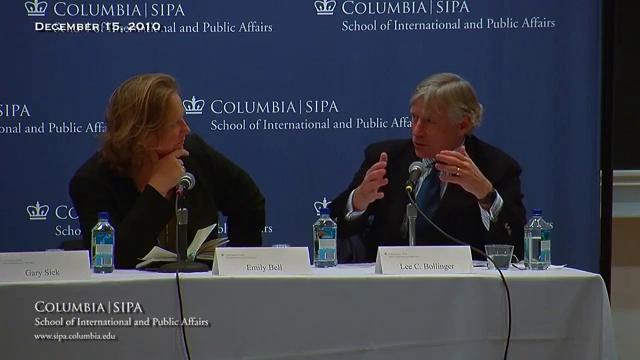

In [ ]:
col_names = ['framenum', 'TLx', 'TLy', 'width', 'speaking_status']

txt_path = '/content/drive/MyDrive/TESI/CODICE/Columbia Dataset/tracks_2_38000_40000/0.txt'

video_path = '/content/drive/MyDrive/TESI/CODICE/Columbia Dataset/Columbia 360.mp4'

df = pd.read_csv(txt_path, sep='\t', header=None, names=col_names, index_col=False)
print(f'TOTAL FRAMES: {df.shape[0]}\nStart Frame: {df.iloc[0]["framenum"]}\nEnd Frame: {df.iloc[-1]["framenum"]}')
# Controllo FULL FRAME
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, df.iloc[500]['framenum'])
ret, frame = cap.read()
cap.release()
cv2.imwrite('full_frame.jpg', frame)
ImagePy('full_frame.jpg')

SPEAKER: lieberman

SIZE: (198, 168, 3) 	  SIZE:(224, 224, 3)
LABEL: 0 		  LABEL: 0
DTYPE: uint8 		  DTYPE: uint8


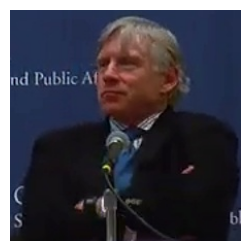

In [ ]:
speaker = 'lieberman' # bell   lieberman   long    sick   bollinger
print(f'SPEAKER: {speaker}')
check_crop(video_path, df.iloc[[1900]], 10,25,move_right=-10, move_lower=20)

In [ ]:
F_Speaker, L_Speaker = get_frames(video_path, df, 10,25,move_right=-15, move_lower=25)
print(f'\nSPEAKER: {speaker}')

100%|██████████| 1880/1880 [00:36<00:00, 51.49it/s]


SPEAKER: lieberman


In [ ]:
append_data_to_person(speaker, F_Speaker, L_Speaker)

New Amount in lieberman: 16400


In [ ]:
#@title Check Datasets Size
print("\t\t\tFRAMES\tLABELS\tTOTAL")
with h5py.File(path, 'r') as f:
    for p in f.keys():
      person = f[p]
      frame_size = person['frames'].attrs.get('data_length', 0)
      label_size = person['labels'].attrs.get('data_length', 0)
      print(f'Group {person.name}:    \t{frame_size} \t{label_size} \t{len(person["frames"])}')

			FRAMES	LABELS	TOTAL
Group /bell:    	37422 	37422 	37422
Group /bollinger:    	15080 	15080 	15080
Group /lieberman:    	16400 	16400 	16400
Group /long:    	29391 	29391 	29391
Group /sick:    	38526 	38526 	38526


In [ ]:
#@title Create Group
with h5py.File(path, 'a') as hf:
    hf.name
    person_group = hf.create_group('lieberman')

    total_data = 16400

    # Create datasets within each group
    person_group.create_dataset('frames', (total_data, 224, 224, 3), dtype='uint8')
    person_group.create_dataset('labels', (total_data,), dtype='uint8')
hf.close()

In [ ]:
#@title Add data to h5 dataset
from PIL import Image as ImageClip

def append_data_to_person(person_id, frames, labels):
    with h5py.File(path, 'a') as hf:
        if person_id in hf:
            person_group = hf[person_id]

            # Get the current data length from the attributes, or default to 0
            current_length = person_group['frames'].attrs.get('data_length', 0)

            # Calculate the index where new data should be inserted
            start_index = current_length
            end_index = start_index + len(frames)

            # Calculate the size of the new data
            new_data_size = end_index - start_index

            # Check if there is enough space in the 'frames' list
            if new_data_size <= len(person_group['frames']) - start_index:
                person_group['frames'][start_index:end_index] = frames
            else:
                print(f"Not enough space in the 'frames' list\nSpace required:{new_data_size} \tSpace Remaining:{len(person_group['frames']) - start_index}")

            # Check if there is enough space in the 'labels' list
            if new_data_size <= len(person_group['labels']) - start_index:
                person_group['labels'][start_index:end_index] = labels
            else:
                print("Not enough space in the 'labels' list")


            # Update the data length attribute
            person_group['frames'].attrs['data_length'] = end_index
            person_group['labels'].attrs['data_length'] = end_index

            print(f"New Amount in {person_id}: {person_group['frames'].attrs.get('data_length')}")
        else:
            print(f"Group '{person_id}' not found in the file.")
    hf.close()


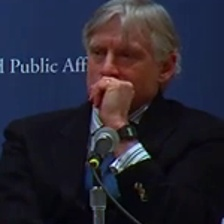

In [ ]:
path = "/content/drive/MyDrive/TESI/CODICE/Columbia Dataset/Frames_labels_dataset/database.h5"
with h5py.File(path, 'r') as hf:
  frame = hf['bollinger']['frames'][0]
  cv2.imwrite('test.jpg', frame)
  display(ImagePy('test.jpg'))

In [ ]:
#@title Add data to h5 but more Memory Efficient
from PIL import Image as ImageClip

def append_data_to_person_efficient(person_id, frames, labels):
    batch_size = 1000
    with h5py.File(path, 'a') as hf:
        if person_id in hf:
            person_group = hf[person_id]

            # Get the current data length from the attributes, or default to 0
            current_length = person_group['frames'].attrs.get('data_length', 0)

            for i in range(0, len(frames), batch_size):
                # Calculate the index where new data should be inserted
                start_index = current_length + i
                end_index = start_index + batch_size

                # Process the images in the current batch
                images = [Image.fromarray(frame) for frame in frames[i:i+batch_size]]
                images = [image.convert('RGB') if image.mode != 'RGB' else image for image in images]
                images = torch.stack([preprocess(image) for image in images])#.to(device)

                # Append new data
                person_group['frames'][start_index:end_index] = images
                person_group['labels'][start_index:end_index] = labels[i:i+batch_size]

            # Update the data length attribute
            person_group['frames'].attrs['data_length'] = end_index
            person_group['labels'].attrs['data_length'] = end_index


            print(f"New Amount in {person_id}: {person_group['frames'].attrs.get('data_length')}")
        else:
            print(f"Group '{person_id}' not found in the file.")
    hf.close()


## CONTROLLI VARI

In [ ]:
#@title Check Data
with h5py.File(path, 'r') as hf:
  group = hf['bell']
  frame = group['frames'][37422]
  print(frame[:10])

[[[91 51 38]
  [91 51 38]
  [91 51 38]
  ...
  [88 49 39]
  [88 49 39]
  [88 49 39]]

 [[91 51 38]
  [91 51 38]
  [91 51 38]
  ...
  [88 49 39]
  [88 49 39]
  [88 49 39]]

 [[91 51 38]
  [91 51 38]
  [91 51 38]
  ...
  [88 49 39]
  [88 49 39]
  [88 49 39]]

 ...

 [[89 51 38]
  [89 51 38]
  [89 51 38]
  ...
  [88 50 37]
  [88 50 37]
  [88 50 37]]

 [[89 51 38]
  [89 51 38]
  [89 51 38]
  ...
  [88 50 37]
  [88 50 37]
  [88 50 37]]

 [[89 51 38]
  [89 51 38]
  [89 51 38]
  ...
  [88 50 37]
  [88 50 37]
  [88 50 37]]]


In [ ]:
#@title Cancella Gruppo nel dataset
import h5py

# Open the HDF5 file in append mode
with h5py.File(path, 'a') as f:
    # Delete the group
    del f['sick']


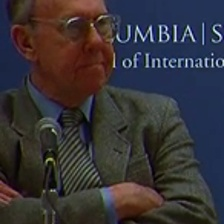

In [ ]:
#@title DIsplay CLIP processed image
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

f = Image.fromarray(Test_List[0])
f = f.convert('RGB') if f.mode != 'RGB' else f
f = preprocess(f)

# CLIP's preprocess function normalizes the image with the mean and std deviation
# We need to reverse this process to display the image correctly
unnormalize = transforms.Normalize((-0.48145466/0.26862954, -0.4578275/0.26130258, -0.40821073/0.27577711), (1/0.26862954, 1/0.26130258, 1/0.27577711))

# Convert tensor to PIL Image
img = transforms.ToPILImage()(unnormalize(f)).convert("RGB")
img = np.array(img)
# Display the image
cv2.imwrite('test.jpg', img)
display(ImagePy('test.jpg'))

In [ ]:

import h5py

# Open the HDF5 file
with h5py.File(path, 'r') as f:
    # Access the 'bell' group
    bell_group = f['bell']

    # Load the first 1000 frames and labels
    frames = bell_group['frames'][:1000]
    labels = bell_group['labels'][:1000]


In [17]:
#@title Count Data
with h5py.File(path, 'r') as hf:
  tot = 0
  tot_0 = 0
  tot_1 = 1
  print(f"\t\t\t NOT Speaking \t Speaking")
  for p in ['bell', 'sick', 'long', 'bollinger', 'lieberman']:
    c = 0
    c_1 = 0
    c_0 = 0
    for i in hf[p]['labels']:
      c += 1
      if i == 0: c_0 += 1
      else: c_1 += 1

    print(f"{p} ha {c} dati:\t\t{c_0} \t {c_1}")
    tot += c
    tot_1 += c_1
    tot_0 += c_0

  print(f"TOT FRAMES: {tot} \t {tot_0} \t {tot_1}")

			 NOT Speaking 	 Speaking
bell ha 37422 dati:		18191 	 19231
sick ha 38526 dati:		23979 	 14547
long ha 29391 dati:		16738 	 12653
bollinger ha 15080 dati:		9284 	 5796
lieberman ha 16400 dati:		12475 	 3925
TOT FRAMES: 136819 	 80667 	 56153


In [7]:
print(f"\t\t\t NOT Speaking \t Speaking")

			 NOT Speaking 	 Speaking


In [2]:
56153/136819

0.410418143678875

In [3]:
80667/136819

0.5895891652475168